## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

A client, who owns "**Ampe Decoración**", a “Furniture / Home Store” located in Vigo (Galicia/Spain), wants to open his second store in the city so the goal of this Project consists in evaluate the best location to open this second store.

The intention of the study is to find the best possibility among the center and northern boroughs because the first store is placed on a borough in the south of the city so we can catch higher demand.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

### Data  <a name="data"></a>

The lack of accessible datasets that could help us to define the data about the city leads us to the necessity of create manually our own sets. In order to accomplish this task, we will have to review the INE portal (Instituto Nacional de Estadística – Statistic National Institute), Wikipedia Google Maps and Concello de Vigo portal (Vigo Town Hall) and merge the information retrieved.

We will create two different datasets:
    
    1. CSV file which contains the latitude, longitude and evolution of the population in each borough from 2000 to 2020

<img src = "imaxe01.png" width = 800>

    2. Json file with the latitude and longitude of each of the neighborhoods in each one of the boroughs described in the csv file

<img src = "imaxe02.png" width = 800>

Once we have completed our datasets, we will use Foursquare API to find the location of all the stores similar to the store that our client owns and segment the best location.


### Library imports

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis    
from pandas.io.json import json_normalize # tranforming json file into a pandas dataframe library

import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import matplotlib.pyplot as plt
import pyproj
import math
import pickle
import json # library to handle JSON files

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

import folium # plotting library
from folium import plugins
from folium.plugins import HeatMap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

Let's first find the latitude & longitude of Vigo city center, using Nominatim API.

In [2]:
address = 'Vigo'
geolocator = Nominatim(user_agent="centro_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

vigo_center = [latitude, longitude]

print("Centro da cidade location = {} -> lat={}, long={}".format(location,latitude,longitude))

Centro da cidade location = Vigo, Pontevedra, Galicia, 36202, España -> lat=42.2376602, long=-8.7247205


Now we locate the first store (**"Ampe decoración"**) because we will try to find the best location for the second store on a place not covered by this one

In [3]:
ampeaddress = 'Ampe Decoración'

ampegeolocator = Nominatim(user_agent="ampe_agent")
ampelocation = ampegeolocator.geocode(ampeaddress)
ampelatitude = ampelocation.latitude
ampelongitude = ampelocation.longitude

We will create a rectangular grid of area candidates, equaly spaced, around the city center. Our neighborhoods will be defined as circular areas with a radius of 300 meters, so our neighborhood centers will be 600 meters apart.

To accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters).

In [4]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

x, y = lonlat_to_xy(vigo_center[1], vigo_center[0])
lo, la = xy_to_lonlat(x, y)

In [5]:
vigo_center_x, vigo_center_y = lonlat_to_xy(vigo_center[1], vigo_center[0]) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = vigo_center_x - 4650
x_step = 600
y_min = vigo_center_y  - 1500 - (int(30/k)*k*600 - 12000)/2
y_step = 600 * k 


latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(9/k)):
    y = (y_min + i * y_step)
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 17):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(vigo_center_x, vigo_center_y, x, y)
        if (distance_from_center <= 14001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

170 candidate neighborhood centers generated.


In [6]:
map_vigo = folium.Map(location=vigo_center, zoom_start=12)
folium.Marker(vigo_center, popup='Centro').add_to(map_vigo)
for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_vigo)
map_vigo

Once we have created the datagrid we put all the locations in a dataframe

In [7]:
df_locations = pd.DataFrame({'Latitude': latitudes,
                             'Longitude': longitudes,
                             'X': xs,
                             'Y': ys,
                             'Distance from center': distances_from_center})



Let's, now, save all the locations in a file

In [8]:
df_locations.to_pickle('./locations.pkl')

### Foursquare

We will use Foursquare to retieve all the **Furniture/Home Stores**, **Carpet Stores** and **Fabric Stores** on a radius os 350 metres around each center

In [9]:
# Foursquare credentials

CLIENT_ID = 'QSZNVLLCV5FXDRWUTEGZ1MZII0BMXWLNA3FWLKDWUWH14T10' # your Foursquare ID
CLIENT_SECRET = 'KXRB331GPSOCSLLZYICDNKC5RBT1B3KYMRZTUIJX3G25HW1B' # your Foursquare Secret
#CLIENT_ID = 'LSKLGQAGHXRIC5PR53VDMI5OVBGOJUBTEKVW0EC5WNCFXKN1'
#CLIENT_SECRET = 'ZBBJ454OFS0NKEZ3YZF4ILISUTRWENA4N2C41BCFM0BBUNVM'

#CLIENT_ID = '51F1155UFX5KSBA4PALMYRUB0TVGTUSAD5Z3G3JNOTBJOR3X' # your Foursquare ID
#CLIENT_SECRET = 'THQ1PDXRIVHUEOCDIH3AKJEVAIHXB4OL25GK4USCMTJIL50K' # your Foursquare Secret


In [10]:
# 4bf58dd8d48988d1f8941735 -> Furniture / Home Store
# 52f2ab2ebcbc57f1066b8b2a -> Carpet Store
# 52f2ab2ebcbc57f1066b8b26 -> Fabric Shop

consulta = "4bf58dd8d48988d1f8941735,52f2ab2ebcbc57f1066b8b2a,52f2ab2ebcbc57f1066b8b26"

In [11]:
def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def format_address(location):
    address = ', '.join(location['formattedAddress'])
    return address

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=350, limit=100):
    version = '20180724'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]
    except:
        venues = []      
    return venues

In [12]:
# Let's now go over our neighborhood locations and get nearby stores; 
# we'll also maintain a dictionary of all found stores

def get_deco(lats, lons):
    decoracion = {}
    location_deco = []

    print('Obtaining venues around candidate locations:', end='')
    for lat, lon in zip(lats, lons):
        # Using radius=350 to meke sure we have overlaps/full coverage so we don't miss any decoration store 
        # (we're using dictionaries to remove any duplicates resulting from area overlaps)
        venues = get_venues_near_location(lat, lon, consulta, CLIENT_ID, 
                                          CLIENT_SECRET, radius=350, limit=100)
        
        area_deco = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
            deco = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address,venue_distance, x, y)
            if venue_distance<=1000:
                area_deco.append(deco)
            decoracion[venue_id] = deco
        location_deco.append(area_deco)
        print(' .', end='')
    print(' done.')
    return decoracion, location_deco

# Try to load from local file system in case we did this before
decoracion_stores = {}
loaded = False
try:
    with open('deco_stores.pkl', 'rb') as f:
        decoracion_stores = pickle.load(f)
    with open('location_stores.pkl', 'rb') as f:
        location_deco = pickle.load(f)
    print('Decoration Stores data loaded.')
    loaded = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    decoracion_stores, location_deco = get_deco(latitudes, longitudes)
    # Let's persists this in local file system
    with open('deco_stores.pkl', 'wb') as f:
        pickle.dump(decoracion_stores, f)
    with open('location_stores.pkl', 'wb') as f:
        pickle.dump(location_deco, f)
        

Decoration Stores data loaded.


In [13]:
print('Total number of stores:', len(decoracion_stores))
print('Average number of stores in neighborhood:', np.array([len(r) for r in location_deco]).mean())

Total number of stores: 75
Average number of stores in neighborhood: 0.6058823529411764


In [14]:
print('List of all stores')
print('-----------------------')
for r in list(decoracion_stores.values())[:10]:
    print(r)
print('...')
print('Total:', len(decoracion_stores))

List of all stores
-----------------------
('5be1ba121af8520039f5dd5d', 'Copefri Atlántico', 42.20320906551064, -8.704837263944343, 'Avenida Alcalde Lavadores, 120, BAJO, 36312 Pontevedra Galicia, España', 60, -1461072.8244225245, 4953324.820731912)
('4faaaabbe4b02b45e626f2a7', 'Dister', 42.196783, -8.763862, 'España', 210, -1466181.354472213, 4954054.579119903)
('527e86cd11d2708b0932195a', 'Mymobel', 42.197133, -8.763875, 'Vigo Galicia, España', 339, -1466170.879773266, 4954093.949466563)
('4e18726b483b5cfa49ca466f', 'MerkaMueble', 42.215798319813146, -8.675667221093658, 'España', 344, -1458239.1211951792, 4954015.922906421)
('574d5835cd1031841c760e2e', 'Muebles BOOM', 42.214203, -8.673215, 'España', 247, -1458088.1958054823, 4953778.000528032)
('5b266845f62f2b002cc3f288', 'NOVOSTYLO', 42.19893781943207, -8.762142687310757, 'Carretera Camposancos, 98, 36213 Vigo Galicia, España', 107, -1465967.5869498304, 4954252.803615083)
('522450d104935249c94428cb', 'Muebles El Rebajón De La Ardill

In [15]:
print('Stores around location')
print('---------------------------')
for i in range(0, len(location_deco)):
    rs = location_deco[i][:8]
    names = ', '.join([r[1] for r in rs])
    print('Stores around location {}: {}'.format(i+1, names))

Stores around location
---------------------------
Stores around location 1: 
Stores around location 2: 
Stores around location 3: 
Stores around location 4: 
Stores around location 5: 
Stores around location 6: 
Stores around location 7: 
Stores around location 8: 
Stores around location 9: Copefri Atlántico
Stores around location 10: 
Stores around location 11: 
Stores around location 12: 
Stores around location 13: 
Stores around location 14: 
Stores around location 15: 
Stores around location 16: 
Stores around location 17: 
Stores around location 18: Dister, Mymobel
Stores around location 19: 
Stores around location 20: 
Stores around location 21: 
Stores around location 22: 
Stores around location 23: 
Stores around location 24: 
Stores around location 25: 
Stores around location 26: 
Stores around location 27: 
Stores around location 28: 
Stores around location 29: 
Stores around location 30: 
Stores around location 31: MerkaMueble, Muebles BOOM
Stores around location 32: Mueble

In [16]:
map_deco = folium.Map(location=vigo_center, zoom_start=12)
folium.Marker(vigo_center, popup='centro').add_to(map_deco)
for res in decoracion_stores.values():
    lat = res[2]; lon = res[3]
    color = 'red'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_deco)
map_deco

In this map we located all the stores in area within few kilometers from the center of the city. We also know which stores exactly are in vicinity of every neighborhood candidate center.

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new home store!

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Vigo that have low decoration stores density. We will limit our analysis to area ~7km around city center.

In first step we have collected the required **data: location of every store within ~7km from Vigo center** (according to Foursquare categorization).

Second step in our analysis will be calculation and exploration of '**decoration stores density**' across different boroughs of Vigo - we will use **heatmaps** and demographic statistics to identify a few promising areas close to center as our client wants with low number of stores in general and focus our attention on those areas.

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with the client: we will take into consideration locations with **no more than two stores in radius of 250 meters** and near 3 kilometers away from the original store.

We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by our client.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of stores in every area candidate**:

In [17]:
location_deco_count = [len(res) for res in location_deco]

df_locations['Stores in area'] = location_deco_count

print('Average number of stores in every area with radius=300m:', np.array(location_deco_count).mean())

df_locations

Average number of stores in every area with radius=300m: 0.6058823529411764


Latitude  Longitude             X             Y  Distance from center  \
0    42.191341  -8.758749 -1.465937e+06  4.953322e+06           6140.143967   
1    42.192803  -8.752099 -1.465337e+06  4.953322e+06           5730.738864   
2    42.194265  -8.745448 -1.464737e+06  4.953322e+06           5357.365764   
3    42.195727  -8.738798 -1.464137e+06  4.953322e+06           5028.058068   
4    42.197188  -8.732146 -1.463537e+06  4.953322e+06           4751.985683   
5    42.198649  -8.725494 -1.462937e+06  4.953322e+06           4538.872980   
6    42.200109  -8.718842 -1.462337e+06  4.953322e+06           4397.882210   
7    42.201569  -8.712189 -1.461737e+06  4.953322e+06           4336.054420   
8    42.203029  -8.705536 -1.461137e+06  4.953322e+06           4356.761175   
9    42.204489  -8.698882 -1.460537e+06  4.953322e+06           4458.852760   
10   42.205948  -8.692228 -1.459937e+06  4.953322e+06           4636.956753   
11   42.207407  -8.685573 -1.459337e+06  4.953322e+06           4882.762326   
12   42.208865  -8.678918 -1.458737e+06  4.953322e+06           5186.652864   
13   42.210323  -8.672262 -1.458137e+06  4.953322e+06           5539.076451   
14   42.211781  -8.665606 -1.457537e+06  4.953322e+06           5931.388365   
15   42.213239  -8.658949 -1.456937e+06  4.953322e+06           6356.207040   
16   42.214696  -8.652292 -1.456337e+06  4.953322e+06           6807.449444   
17   42.194892  -8.763777 -1.466237e+06  4.953841e+06           6013.975816   
18   42.196355  -8.757127 -1.465637e+06  4.953841e+06           5563.084137   
19   42.197817  -8.750476 -1.465037e+06  4.953841e+06           5142.752679   
20   42.199279  -8.743825 -1.464437e+06  4.953841e+06           4761.082347   
21   42.200740  -8.737174 -1.463837e+06  4.953841e+06           4428.081426   
22   42.202202  -8.730522 -1.463237e+06  4.953841e+06           4155.466895   
23   42.203663  -8.723870 -1.462637e+06  4.953841e+06           3955.743307   
24   42.205123  -8.717217 -1.462037e+06  4.953841e+06           3840.300133   
25   42.206584  -8.710563 -1.461437e+06  4.953841e+06           3816.792516   
26   42.208043  -8.703909 -1.460837e+06  4.953841e+06           3886.888873   
27   42.209503  -8.697255 -1.460237e+06  4.953841e+06           4045.726772   
28   42.210962  -8.690600 -1.459637e+06  4.953841e+06           4283.445472   
29   42.212421  -8.683945 -1.459037e+06  4.953841e+06           4587.799594   
30   42.213880  -8.677289 -1.458437e+06  4.953841e+06           4946.504333   
31   42.215338  -8.670632 -1.457837e+06  4.953841e+06           5348.635818   
32   42.216796  -8.663976 -1.457237e+06  4.953841e+06           5785.145211   
33   42.218253  -8.657318 -1.456637e+06  4.953841e+06           6248.832300   
34   42.199906  -8.762156 -1.465937e+06  4.954361e+06           5456.596219   
35   42.201368  -8.755505 -1.465337e+06  4.954361e+06           4991.436897   
36   42.202831  -8.748854 -1.464737e+06  4.954361e+06           4557.898890   
37   42.204293  -8.742202 -1.464137e+06  4.954361e+06           4165.866332   
38   42.205754  -8.735550 -1.463537e+06  4.954361e+06           3828.112106   
39   42.207216  -8.728898 -1.462937e+06  4.954361e+06           3560.118298   
40   42.208677  -8.722245 -1.462337e+06  4.954361e+06           3378.526645   
41   42.210137  -8.715591 -1.461737e+06  4.954361e+06           3297.641929   
42   42.211598  -8.708937 -1.461137e+06  4.954361e+06           3324.822145   
43   42.213058  -8.702283 -1.460537e+06  4.954361e+06           3457.519674   
44   42.214517  -8.695628 -1.459937e+06  4.954361e+06           3684.351000   
45   42.215976  -8.688972 -1.459337e+06  4.954361e+06           3989.290951   
46   42.217435  -8.682316 -1.458737e+06  4.954361e+06           4355.966287   
47   42.218894  -8.675660 -1.458137e+06  4.954361e+06           4770.161663   
48   42.220352  -8.669003 -1.457537e+06  4.954361e+06           5220.578732   
49   42.221810  -8.662345 -1.456937e+06  4.954361e+06   

OK, now let's calculate the **distance to nearest store from every area candidate center** (not only those within 300m - we want distance to closest one, regardless of how distant it is).

In [18]:
distances_to_deco_store = []

for area_x, area_y in zip(xs, ys):
    min_distance = 300
    for res in decoracion_stores.values():
        res_x = res[6]
        res_y = res[7]
        d = calc_xy_distance(area_x, area_y, res_x, res_y)
        if d<min_distance:
            min_distance = d
    distances_to_deco_store.append(min_distance)

df_locations['Distance to Store'] = distances_to_deco_store

In [19]:
print('Average distance to closest Store from each area center:', df_locations['Distance to Store'].mean())

Average distance to closest Store from each area center: 276.78574474913165


OK, so **on average Home Store can be found within ~300m** from every area center candidate. That's fairly close, so we need to filter our areas carefully!

In [20]:
deco_latlons = [[res[2], res[3]] for res in decoracion_stores.values()]

In [21]:
map_vigo = folium.Map(location=vigo_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_vigo) #cartodbpositron cartodbdark_matter
HeatMap(deco_latlons).add_to(map_vigo)
folium.Marker(vigo_center).add_to(map_vigo)
folium.Circle(vigo_center, radius=1000, fill=False, color='blue').add_to(map_vigo)
folium.Circle(vigo_center, radius=2000, fill=False, color='white').add_to(map_vigo)
folium.Circle(vigo_center, radius=3000, fill=False, color='white').add_to(map_vigo)

folium.CircleMarker(
    [ampelatitude, ampelongitude],
    radius=10,
    color='red',
    popup='Ampe Decoraci&oacute;n',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=1000, fill=False, color='blue').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=2000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=3000, fill=False, color='red').add_to(map_vigo)

map_vigo

As we can see in the map the distance between the original store and the center of the city is about 3 kilometers and the heatmap reveals that there is a straight line of home stores from "Ampe decoración" (red circle) to the center of the city (blue marker) what leads us to dissaprove placing the second store on these locations but we discover an area on the north-east and other on the east of the city that seems optimal to continue with our analysis.



Our next step will be study all the boroughs and neighborhoods of the city trying to find clean spaces to locate the second store.

In [22]:
roi_x_min = vigo_center_x - 2000
roi_y_max = vigo_center_y + 1000
roi_width = 5000
roi_height = 5000
roi_center_x = roi_x_min + 2500
roi_center_y = roi_y_max - 2500
roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
roi_center = [roi_center_lat, roi_center_lon]

map_vigo = folium.Map(location=roi_center, zoom_start=14)
HeatMap(deco_latlons).add_to(map_vigo)
folium.Marker(vigo_center).add_to(map_vigo)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_vigo)

folium.CircleMarker(
    [ampelatitude, ampelongitude],
    radius=10,
    color='red',
    popup='Ampe Decoraci&oacute;n',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=1000, fill=False, color='blue').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=2000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=3000, fill=False, color='red').add_to(map_vigo)

map_vigo

In [23]:
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = 100
y_step = 100 * k 
roi_y_min = roi_center_y - 2500

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
for i in range(0, int(51/k)):
    y = roi_y_min + i * y_step
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 51):
        x = roi_x_min + j * x_step + x_offset
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 5001):
            lon, lat = xy_to_lonlat(x, y)
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), 'candidate neighborhood centers generated.')

2958 candidate neighborhood centers generated.


In [24]:
def count_deco_nearby(x, y, decoracion, radius=250):    
    count = 0
    for res in decoracion.values():
        res_x = res[6]; res_y = res[7]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=radius:
            count += 1
    return count

def find_nearest_deco(x, y, decoracion):
    d_min = 300
    for res in decoracion.values():
        res_x = res[6]; res_y = res[7]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=d_min:
            d_min = d
    return d_min

roi_deco_counts = []
roi_deco_distances = []
print('Generating data on location candidates... ', end='')
for x, y in zip(roi_xs, roi_ys):
    count = count_deco_nearby(x, y, decoracion_stores, radius=250)
    roi_deco_counts.append(count)
    distance = find_nearest_deco(x, y, decoracion_stores)
    roi_deco_distances.append(distance)
print('done.')

Generating data on location candidates... done.


In [25]:
# Let's put this into dataframe
df_deco_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys,
                                 'Decoraction store nearby':roi_deco_counts,
                                 'Distance to Decoraction store':roi_deco_distances})

df_deco_locations.head()

Latitude  Longitude             X             Y  Decoraction store nearby  \
0  42.199937  -8.733238 -1.463537e+06  4.953655e+06                         0   
1  42.200180  -8.732130 -1.463437e+06  4.953655e+06                         0   
2  42.200424  -8.731021 -1.463337e+06  4.953655e+06                         0   
3  42.200667  -8.729912 -1.463237e+06  4.953655e+06                         0   
4  42.200911  -8.728804 -1.463137e+06  4.953655e+06                         0   

   Distance to Decoraction store  
0                          300.0  
1                          300.0  
2                          300.0  
3                          300.0  
4                          300.0

In [26]:
good_deco_count = np.array((df_deco_locations['Decoraction store nearby']<=2))
print('Locations with no more than two decorations stores nearby:', good_deco_count)

good_deco_distance = np.array(df_deco_locations['Distance to Decoraction store']>=300)
print('Locations with no Decoration Stores within 300m:', good_deco_distance.sum())

good_locations = np.logical_and(good_deco_count, good_deco_distance)
print('Locations with both conditions met:', good_locations.sum())

df_good_locations = df_deco_locations[good_locations]

Locations with no more than two decorations stores nearby: [ True  True  True ...  True  True  True]
Locations with no Decoration Stores within 300m: 2088
Locations with both conditions met: 2088


In [27]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

In [28]:
map_vigo = folium.Map(location=roi_center, zoom_start=14)
HeatMap(good_locations, radius=25).add_to(map_vigo)
folium.Marker(vigo_center).add_to(map_vigo)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_vigo)

folium.CircleMarker(
    [ampelatitude, ampelongitude],
    radius=10,
    color='red',
    popup='Ampe Decoraci&oacute;n',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=1000, fill=False, color='blue').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=2000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=3000, fill=False, color='red').add_to(map_vigo)

map_vigo

In [29]:
from sklearn.cluster import KMeans

number_of_clusters = 15

good_xys = df_good_locations[['X', 'Y']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]


In [30]:
map_vigo = folium.Map(location=roi_center, zoom_start=14)
folium.Marker(vigo_center).add_to(map_vigo)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#00000000', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_vigo)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_vigo)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_vigo)

folium.CircleMarker(
    [ampelatitude, ampelongitude],
    radius=10,
    color='red',
    popup='Ampe Decoraci&oacute;n',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=1000, fill=False, color='blue').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=2000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=3000, fill=False, color='red').add_to(map_vigo)

map_vigo

In [31]:
def get_address(latitude, longitude, verbose=False):
    try:
        address = 'Santiago de Vigo, Vigo'
        geolocator = Nominatim(user_agent="centro_agent")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        return location
    except:
        return None

In [32]:
candidate_area_addresses = []
print('==============================================================')
print('Addresses of centers of areas recommended for further analysis')
print('==============================================================\n')
for lon, lat in cluster_centers:
    addr = get_address(lat, lon)
    candidate_area_addresses.append(addr)    
    x, y = lonlat_to_xy(lon, lat)
    d = calc_xy_distance(x, y, vigo_center_x, vigo_center_y)
    print('{}{} => {:.1f}km from santiago de Vigo'.format(addr, ' '*(50-len(addr)), d/1000))
    

Addresses of centers of areas recommended for further analysis

Santiago de Vigo, Vigo, Pontevedra, Galicia, 36201, España                                                 => 3.7km from santiago de Vigo
Santiago de Vigo, Vigo, Pontevedra, Galicia, 36201, España                                                 => 2.6km from santiago de Vigo
Santiago de Vigo, Vigo, Pontevedra, Galicia, 36201, España                                                 => 2.5km from santiago de Vigo
Santiago de Vigo, Vigo, Pontevedra, Galicia, 36201, España                                                 => 1.2km from santiago de Vigo
Santiago de Vigo, Vigo, Pontevedra, Galicia, 36201, España                                                 => 3.4km from santiago de Vigo
Santiago de Vigo, Vigo, Pontevedra, Galicia, 36201, España                                                 => 3.6km from santiago de Vigo
Santiago de Vigo, Vigo, Pontevedra, Galicia, 36201, España                                                 =

In [33]:
map_vigo = folium.Map(location=roi_center, zoom_start=13)
folium.Circle(vigo_center, radius=50, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_vigo)
for lonlat, addr in zip(cluster_centers, candidate_area_addresses):
    folium.Marker([lonlat[1], lonlat[0]]).add_to(map_vigo) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.05).add_to(map_vigo)

folium.CircleMarker(
    [ampelatitude, ampelongitude],
    radius=10,
    color='red',
    popup='Ampe Decoraci&oacute;n',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=1000, fill=False, color='blue').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=2000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=3000, fill=False, color='red').add_to(map_vigo)

map_vigo

### Retrieving the boroughs and choosing candidates

Even we have a first analysis about the situation of the home stores in the city of Vigo we will make a further analysis, in this case, about the demographical situation of the population and the geographical location of each one of the boroughs.

For this purpose we load the csv file that we have created which contains the information of the 19 boroughs in Vigo:
<ul>
    <li>Latitude</li>
    <li>Longitude</li>
    <li>Population from 2000 to 2020</li>
</ul>

In [34]:
datos = pd.read_csv('datos/vigo-nomenclator.csv')
datos

Borough   Latitude  Lonxitude    2000    2001    2002    2003  \
0            Alcabre  42.218101  -8.767390    2407    2567    2778    2997   
1              Beade  42.186619  -8.698572    5403    5471    5458    5501   
2           Bembrive  42.198095  -8.676560    3948    3982    3980    4063   
3             Cabral  42.224007  -8.656734    6879    6854    6786    6789   
4            Candeán  42.246082  -8.657308    4567    4600    4642    4699   
5          Castrelos  42.206780  -8.723340    7914    7908    7846    7849   
6           Comesaña  42.199353  -8.756377    2690    2809    2953    3031   
7             Coruxo  42.194383  -8.780007    5201    5282    5284    5344   
8          Freixeiro  42.219188  -8.728871    5644    5805    5813    5928   
9          Lavadores  42.226161  -8.693599   16485   16494   16483   16667   
10            Matamá  42.193900  -8.731599    4233    4239    4254    4247   
11             Navia  42.208304  -8.767390    2090    2141    2164    2190   
12               Oia  42.190314  -8.799873    3701    3836    3896    3910   
13  Santiago de Vigo  42.237001  -8.712330  285526  287282  288324  292566   
14           Sárdoma  42.216684  -8.711356    2004    1978    1968    1992   
15            Saiáns  42.170616  -8.811470    1070    1064    1068    1067   
16              Teis  42.253903  -8.680658    2397    2388    2377    2402   
17         Valadares  42.177009  -8.727624    5328    5426    5453    5468   
18            Zamáns  42.157602  -8.685751     742     753     760     780   

      2004    2005    2006    2007    2008    2009    2010    2011    2012  \
0     3067    3139    3183    3335    3415    3438    3530    3556    3560   
1     5453    5458    5430    5435    5444    5455    5470    5447    5437   
2     4074    4155    4290    4330    4343    4360    4362    4402    4413   
3     6738    6769    6772    6773    6824    6806    6786    6800    6759   
4     4691    4723    4745    4785    4799    4842    4846    4857    4884   
5     7770    7823    7767    7772    7868    7927    8002    8047    7995   
6     3178    3290    3544    3716    4014    4361    4593    5138    5811   
7     5353    5372    5387    5360    5299    5347    5308    5261    5349   
8     6009    6095    6070    6093    6133    6171    6162    6158    6058   
9    16775   16952   17064   17176   17339   17727   17844   17984   17956   
10    4206    4151    4126    4047    4029    3997    3939    3921    3868   
11    2206    2211    2266    2733    3034    3503    3960    4395    5205   
12    3947    3998    3953    3968    4010    4026    4020    4015    3972   
13  292059  293725  293255  294772  295703  297332  297124  297241  297355   
14    1965    2024    2031    2098    2184    2201    2219    2254    2303   
15    1048    1082    1104    1145    1171    1169    1156    1159    1153   
16    2349    2330    2313    2301    2272    2262    2273    2229    2453   
17    5484    5471    5475    5409    5410    5419    5406    5387    5356   
18     792     789     804     791     804     814     834     840     842   

      2013    2014    2015    2016    2017    2018    2019    2020  
0     3673    3822    3895    3998    4031    4171    4241    4300  
1     5409    5377    5365    5303    5296    5309    5322    5292  
2     4427    4425    4361    4323    4298    4332    4343    4374  
3     6683    6680    6669    6622    6594    6544    6581    6628  
4     4860    4789    4739    4689    4688    4653    4639    4675  
5     8006    7996    7989    7936    7948    7932    7987    7999  
6     5905    6134    6219    6311    6364    6486    6513    6530  
7     5343    5301    5296    5336    5338    5310    5289    5324  
8     6035    5935    5998    5998    5949    5923    5952    6001  
9    17878   17669   17587   17490   17484   17468   17522   17514  
10    3880    3831    3801    3809    3784    3711    3716    3669  
11    5458    5584    5721    5871    6026    6074    6152    6

Using this file we can create a map using the **"Stamen Terrain"** tile and we can start removing boroughs due their situation for further analysis

In [35]:
# create map of New York using latitude and longitude values
map_vigo = folium.Map(location=vigo_center, zoom_start=11, tiles="Stamen Terrain")

# add markers to map
for lat, lng, borough in zip(datos['Latitude'], datos['Lonxitude'], datos['Borough']):
    label = borough
    label = label.replace("á", "&aacute;").replace("ñ", "&ntilde;")
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_vigo)  
label = "Center of the city"
folium.Marker(vigo_center, popup=label).add_to(map_vigo)
folium.Circle(vigo_center, radius=1000, fill=False, color='blue').add_to(map_vigo)
folium.Circle(vigo_center, radius=2000, fill=False, color='blue').add_to(map_vigo)
folium.Circle(vigo_center, radius=3000, fill=False, color='blue').add_to(map_vigo)

map_vigo

In this first approach to the morphology of the city we discover that some boroughs are not suitable due their hilly localization so we will avoid them in our investigation. These boroughs are located in the south-east, east and north-east and they are **Candeán**, **Cabral**, **Bembrive**, **Beade**, **Valadares** and **Zamáns**.

Now that we excluded some of the boroughs, those that seems not to fit because their bad localization we focus on the remaining 12 boroughs and, as we can see, they are all located on the north face aliigned to the coast line.

Our third conclusion is that on a radius of 3 kilometers around the city center we find 4 boroughs which seems to be the perfect ones, but lets analize a little deeper the situation

In [36]:
boroughsExcluded = ["Candeán", "Cabral", "Bembrive", "Beade", "Valadares", "Zamáns"]
for i in boroughsExcluded:
    datos.drop(datos[datos['Borough'] == i].index, inplace=True)
datos

Borough   Latitude  Lonxitude    2000    2001    2002    2003  \
0            Alcabre  42.218101  -8.767390    2407    2567    2778    2997   
5          Castrelos  42.206780  -8.723340    7914    7908    7846    7849   
6           Comesaña  42.199353  -8.756377    2690    2809    2953    3031   
7             Coruxo  42.194383  -8.780007    5201    5282    5284    5344   
8          Freixeiro  42.219188  -8.728871    5644    5805    5813    5928   
9          Lavadores  42.226161  -8.693599   16485   16494   16483   16667   
10            Matamá  42.193900  -8.731599    4233    4239    4254    4247   
11             Navia  42.208304  -8.767390    2090    2141    2164    2190   
12               Oia  42.190314  -8.799873    3701    3836    3896    3910   
13  Santiago de Vigo  42.237001  -8.712330  285526  287282  288324  292566   
14           Sárdoma  42.216684  -8.711356    2004    1978    1968    1992   
15            Saiáns  42.170616  -8.811470    1070    1064    1068    1067   
16              Teis  42.253903  -8.680658    2397    2388    2377    2402   

      2004    2005    2006    2007    2008    2009    2010    2011    2012  \
0     3067    3139    3183    3335    3415    3438    3530    3556    3560   
5     7770    7823    7767    7772    7868    7927    8002    8047    7995   
6     3178    3290    3544    3716    4014    4361    4593    5138    5811   
7     5353    5372    5387    5360    5299    5347    5308    5261    5349   
8     6009    6095    6070    6093    6133    6171    6162    6158    6058   
9    16775   16952   17064   17176   17339   17727   17844   17984   17956   
10    4206    4151    4126    4047    4029    3997    3939    3921    3868   
11    2206    2211    2266    2733    3034    3503    3960    4395    5205   
12    3947    3998    3953    3968    4010    4026    4020    4015    3972   
13  292059  293725  293255  294772  295703  297332  297124  297241  297355   
14    1965    2024    2031    2098    2184    2201    2219    2254    2303   
15    1048    1082    1104    1145    1171    1169    1156    1159    1153   
16    2349    2330    2313    2301    2272    2262    2273    2229    2453   

      2013    2014    2015    2016    2017    2018    2019    2020  
0     3673    3822    3895    3998    4031    4171    4241    4300  
5     8006    7996    7989    7936    7948    7932    7987    7999  
6     5905    6134    6219    6311    6364    6486    6513    6530  
7     5343    5301    5296    5336    5338    5310    5289    5324  
8     6035    5935    5998    5998    5949    5923    5952    6001  
9    17878   17669   17587   17490   17484   17468   17522   17514  
10    3880    3831    3801    3809    3784    3711    3716    3669  
11    5458    5584    5721    5871    6026    6074    6152    6246  
12    3981    3988    3948    3920    3919    3859    3848    3896  
13  296479  294997  294098  292817  292986  293642  295364  296692  
14    2353    2357    2417    2402    2404    2390    2389    2443  
15    1168    1191    1188    1204    1190    1177    1166    1169  
16    2714    2864    3016    2843    2628    2486    2404    2317

In [37]:
# create map of New York using latitude and longitude values
map_vigo = folium.Map(location=[latitude, longitude], zoom_start=12, tiles="Stamen Terrain")

# add markers to map
for lat, lng, borough in zip(datos['Latitude'], datos['Lonxitude'], datos['Borough']):
    label = borough
    label = label.replace("á", "&aacute;").replace("ñ", "&ntilde;")
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_vigo)  
label = "Center of the city"
folium.Marker([latitude, longitude], popup=label).add_to(map_vigo)
folium.Circle([latitude, longitude], radius=1000, fill=False, color='blue').add_to(map_vigo)
folium.Circle([latitude, longitude], radius=2000, fill=False, color='blue').add_to(map_vigo)
folium.Circle([latitude, longitude], radius=3000, fill=False, color='blue').add_to(map_vigo)

folium.CircleMarker(
    [ampelatitude, ampelongitude],
    radius=10,
    color='red',
    popup='Ampe Decoraci&oacute;n',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=1000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=2000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=3000, fill=False, color='red').add_to(map_vigo)

map_vigo

We have excluded the boroughs and we have placed the first store of our client (in the red point)

As we can see in the map, there are 3 boroughs that should be excluded in our project because they are located up to two kilometers from the store that our client already owns so they are covered (**Freixeiro**, **Castrelos** and **Sárdoma**)

So lets clear, once again, the map and study other keys

In [38]:
boroughsExcluded = ["Freixeiro", "Castrelos", "Sárdoma"]
for i in boroughsExcluded:
    datos.drop(datos[datos['Borough'] == i].index, inplace=True)
datos

Borough   Latitude  Lonxitude    2000    2001    2002    2003  \
0            Alcabre  42.218101  -8.767390    2407    2567    2778    2997   
6           Comesaña  42.199353  -8.756377    2690    2809    2953    3031   
7             Coruxo  42.194383  -8.780007    5201    5282    5284    5344   
9          Lavadores  42.226161  -8.693599   16485   16494   16483   16667   
10            Matamá  42.193900  -8.731599    4233    4239    4254    4247   
11             Navia  42.208304  -8.767390    2090    2141    2164    2190   
12               Oia  42.190314  -8.799873    3701    3836    3896    3910   
13  Santiago de Vigo  42.237001  -8.712330  285526  287282  288324  292566   
15            Saiáns  42.170616  -8.811470    1070    1064    1068    1067   
16              Teis  42.253903  -8.680658    2397    2388    2377    2402   

      2004    2005    2006    2007    2008    2009    2010    2011    2012  \
0     3067    3139    3183    3335    3415    3438    3530    3556    3560   
6     3178    3290    3544    3716    4014    4361    4593    5138    5811   
7     5353    5372    5387    5360    5299    5347    5308    5261    5349   
9    16775   16952   17064   17176   17339   17727   17844   17984   17956   
10    4206    4151    4126    4047    4029    3997    3939    3921    3868   
11    2206    2211    2266    2733    3034    3503    3960    4395    5205   
12    3947    3998    3953    3968    4010    4026    4020    4015    3972   
13  292059  293725  293255  294772  295703  297332  297124  297241  297355   
15    1048    1082    1104    1145    1171    1169    1156    1159    1153   
16    2349    2330    2313    2301    2272    2262    2273    2229    2453   

      2013    2014    2015    2016    2017    2018    2019    2020  
0     3673    3822    3895    3998    4031    4171    4241    4300  
6     5905    6134    6219    6311    6364    6486    6513    6530  
7     5343    5301    5296    5336    5338    5310    5289    5324  
9    17878   17669   17587   17490   17484   17468   17522   17514  
10    3880    3831    3801    3809    3784    3711    3716    3669  
11    5458    5584    5721    5871    6026    6074    6152    6246  
12    3981    3988    3948    3920    3919    3859    3848    3896  
13  296479  294997  294098  292817  292986  293642  295364  296692  
15    1168    1191    1188    1204    1190    1177    1166    1169  
16    2714    2864    3016    2843    2628    2486    2404    2317

From the 19 initial boroughs we have removed 9. Boroughs that we excluded due their inconvenient location.

Once we removed those boroughs that we marked as not suitable due their localization we will, now, focus on the number of inhabitants in each one of them.

For these purpose we will plot the evolution of the number of inhabitants from 2018 to 2020 in the remaining boroughs


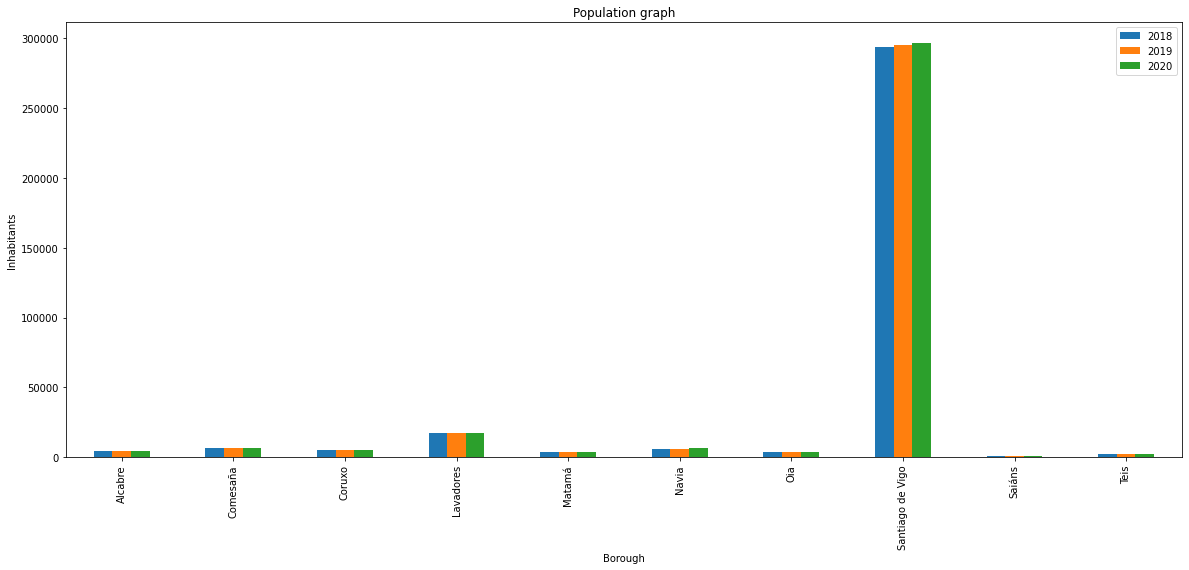

In [39]:
datos.set_index(datos['Borough'], inplace=True)
datos[['2018','2019','2020']].plot(kind="bar",  figsize=(20,8))
plt.title("Population graph")
plt.ylabel('Inhabitants')
plt.xlabel('Borough')
plt.show()

This plot helps us identify the most populated boroughs between the selected ones on the previous stage. At these point we can be sure that there is one borough where we should focus our efforts because it holds near 300000 inhabitants even it is located on a distance of 3 kilometers away from the first store: **"Santiago de Vigo"**.

As we don't want to focus only on one borough we will study the possibilities of another bororugh that is located on the north of the city and on a distance of 3 kilometers from the center of the city: **Lavadores**

In [40]:
selectedBoroughs = ['Santiago de Vigo', 'Lavadores']
latlon_barrios = []
for i in datos.values:
    for j in selectedBoroughs:
        if i[0] == j:
            latlon_barrios.append(i)
columnas = ['Borough', 'Latitude', 'Longitude','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
selection = pd.DataFrame(latlon_barrios, columns=columnas)
selection

Borough   Latitude  Longitude    2000    2001    2002    2003  \
0         Lavadores  42.226161  -8.693599   16485   16494   16483   16667   
1  Santiago de Vigo  42.237001  -8.712330  285526  287282  288324  292566   

     2004    2005    2006    2007    2008    2009    2010    2011    2012  \
0   16775   16952   17064   17176   17339   17727   17844   17984   17956   
1  292059  293725  293255  294772  295703  297332  297124  297241  297355   

     2013    2014    2015    2016    2017    2018    2019    2020  
0   17878   17669   17587   17490   17484   17468   17522   17514  
1  296479  294997  294098  292817  292986  293642  295364  296692

Now I create the map of the city using the library Folium placing the selected boroughs

In [41]:
# create map of New York using latitude and longitude values
map_vigo = folium.Map(location=vigo_center, zoom_start=13, tiles="Stamen Terrain")

label = "Center of the city"
folium.Marker(vigo_center, popup=label).add_to(map_vigo)
folium.Circle(vigo_center, radius=1000, fill=False, color='blue').add_to(map_vigo)
folium.Circle(vigo_center, radius=2000, fill=False, color='blue').add_to(map_vigo)
folium.Circle(vigo_center, radius=3000, fill=False, color='blue').add_to(map_vigo)

# add markers to map
for lat, lng, borough in zip(selection['Latitude'], selection['Longitude'], selection['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vigo)  
map_vigo

At this moment we have reduced the number of boroughs and, now, we can start the process of finding the best location

### Selected Boroughs

#### SANTIAGO DE VIGO

In [42]:
with open('datos/vigo.json') as f:
    neighborhoods = json.load(f)

In [43]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
svigo_neighborhoods = pd.DataFrame(columns=column_names)
svigo_neighborhoods

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

In [44]:
for data in neighborhoods['features']:
    if(data['properties']['borough'] == "Santiago de Vigo"):
        borough = neighborhood_name = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[0]
        neighborhood_lon = neighborhood_latlon[1]
    
        svigo_neighborhoods = svigo_neighborhoods.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)

In [45]:
svigo_latitude = selection[selection['Borough']=="Santiago de Vigo"]['Latitude'][1]
svigo_longitude = selection[selection['Borough']=="Santiago de Vigo"]['Longitude'][1]

svigo_center_x, svigo_center_y = lonlat_to_xy(svigo_longitude, svigo_latitude) # City center in Cartesian coordinates

roi_x_min = svigo_center_x
roi_y_max = svigo_center_y
roi_width = 2000
roi_height = 2000
roi_center_x = roi_x_min
roi_center_y = roi_y_max
roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
roi_center = [roi_center_lat, roi_center_lon]

map_vigo = folium.Map(roi_center, zoom_start=14)
folium.CircleMarker([svigo_latitude, svigo_longitude], radius=5, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_vigo)
map_vigo

In [46]:
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = 100
y_step = 100 * k 
roi_y_min = roi_center_y

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
for i in range(0, int(31/k)):
    y = (roi_y_min + i * y_step) - 1000
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 31):
        x = (roi_x_min + j * x_step + x_offset) - 1000
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 1001):
            lon, lat = xy_to_lonlat(x, y)
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), 'candidate neighborhood centers generated.')

362 candidate neighborhood centers generated.


In [47]:
roi_deco_counts = []
roi_deco_distances = []
print('Generating data on location candidates... ', end='')
for x, y in zip(roi_xs, roi_ys):
    count = count_deco_nearby(x, y, decoracion_stores, radius=250)
    roi_deco_counts.append(count)
    distance = find_nearest_deco(x, y, decoracion_stores)
    roi_deco_distances.append(distance)
print('done.')

Generating data on location candidates... done.


In [48]:
# Let's put this into dataframe
df_deco_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys,
                                 'Decoraction store nearby':roi_deco_counts,
                                 'Distance to Decoraction store':roi_deco_distances})

df_deco_locations.head()

Latitude  Longitude             X             Y  Decoraction store nearby  \
0  42.228497  -8.713775 -1.460981e+06  4.956365e+06                         0   
1  42.228740  -8.712665 -1.460881e+06  4.956365e+06                         0   
2  42.228984  -8.711556 -1.460781e+06  4.956365e+06                         0   
3  42.229227  -8.710447 -1.460681e+06  4.956365e+06                         0   
4  42.229471  -8.709337 -1.460581e+06  4.956365e+06                         0   

   Distance to Decoraction store  
0                     295.446391  
1                     300.000000  
2                     300.000000  
3                     300.000000  
4                     300.000000

In [49]:
good_deco_count = np.array((df_deco_locations['Decoraction store nearby']<=2))
#print('Locations with no more than two decorations stores nearby:', good_deco_count)

good_deco_distance = np.array(df_deco_locations['Distance to Decoraction store']>=300)
#print('Locations with no Decoration Stores within 300m:', good_deco_distance.sum())

good_locations = np.logical_and(good_deco_count, good_deco_distance)
#print('Locations with both conditions met:', good_locations.sum())

df_good_locations = df_deco_locations[good_locations]

In [50]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

In [51]:
map_vigo = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_vigo)
HeatMap(deco_latlons).add_to(map_vigo)
folium.Circle(roi_center, radius=1000, color='white', fill=True, fill_opacity=0.6).add_to(map_vigo)
folium.Marker(roi_center).add_to(map_vigo)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_vigo)

folium.CircleMarker(
    [ampelatitude, ampelongitude],
    radius=10,
    color='red',
    popup='Ampe Decoraci&oacute;n',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=1000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=2000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=3000, fill=False, color='red').add_to(map_vigo)

map_vigo

In [52]:
from sklearn.cluster import KMeans

number_of_clusters = 3

good_xys = df_good_locations[['X', 'Y']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]


In [53]:
map_vigo = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_vigo)
HeatMap(deco_latlons).add_to(map_vigo)
folium.Circle(roi_center, radius=1000, color='white', fill=True, fill_opacity=0.4).add_to(map_vigo)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=True, fill_opacity=0.25).add_to(map_vigo) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_vigo)


for neighborhood,lat,lon in zip(svigo_neighborhoods['Neighborhood'], svigo_neighborhoods['Latitude'],svigo_neighborhoods['Longitude']):
    name =  "Neighbourhood: "+neighborhood
    name = name.replace("Ã³", "&oacute;").replace("Ã¡", "&aacute;").replace("Ãº", "&uacute;").replace("Ã­", "&iacute;")
    folium.Marker([lat, lon], popup=name).add_to(map_vigo)

for lonlat, addr in zip(cluster_centers, candidate_area_addresses):
    folium.CircleMarker([lonlat[1], lonlat[0]], radius=5, color='red',
                        popup="Cluster center", fill=True, fill_color='red', fill_opacity=1).add_to(map_vigo)
      
folium.CircleMarker(
    [ampelatitude, ampelongitude],
    radius=10,
    color='red',
    popup='Ampe Decoraci&oacute;n',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=1000, fill=False, color='blue').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=2000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=3000, fill=False, color='red').add_to(map_vigo)
folium.Marker(roi_center, popup="Santiago de Vigo",
              icon=folium.Icon(color='red')).add_to(map_vigo)

map_vigo

As we can see in the map the most promissing neighborhood in Santiago de Vigo borough is *"**O Corazón de Xesùs**"* located in the north of the borough and more than 3 kilometers away from the original store

In [54]:
map_vigo = folium.Map(location=[42.237001, -8.712330], zoom_start=15)
for lonlat, addr in zip(cluster_centers, candidate_area_addresses):
    folium.Marker([lonlat[1], lonlat[0]],
              icon=folium.Icon(color='blue',icon='ok-sign')).add_to(map_vigo) 
folium.Marker(vigo_center, popup="Center of the city",
              icon=folium.Icon(color='red',icon='info-sign')).add_to(map_vigo)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_vigo) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_vigo)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_vigo)

for neighborhood,lat,lon in zip(svigo_neighborhoods['Neighborhood'], svigo_neighborhoods['Latitude'],svigo_neighborhoods['Longitude']):
    name =  "Neighbourhood: "+neighborhood
    name = name.replace("Ã³", "&oacute;").replace("Ã¡", "&aacute;").replace("Ãº", "&uacute;").replace("Ã­", "&iacute;")
    folium.Marker([lat, lon], popup=name).add_to(map_vigo)

folium.CircleMarker(
    [ampelatitude, ampelongitude],
    radius=10,
    color='red',
    popup='Ampe Decoraci&oacute;n',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=1000, fill=False, color='blue').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=2000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=3000, fill=False, color='red').add_to(map_vigo)

map_vigo

#### Lavadores

In [55]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
lavadores_neighborhoods = pd.DataFrame(columns=column_names)

In [56]:
for data in neighborhoods['features']:
    if(data['properties']['borough'] == "Lavadores"):
        borough = neighborhood_name = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[0]
        neighborhood_lon = neighborhood_latlon[1]
    
        lavadores_neighborhoods = lavadores_neighborhoods.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)

In [57]:
lavadores_neighborhoods

Borough Neighborhood   Latitude  Longitude
0  Lavadores    A Bagunda  42.224772  -8.697769
1  Lavadores     Cambeses  42.228851  -8.685905
2  Lavadores  A Ceboleira  42.229202  -8.708262
3  Lavadores      O Couto  42.229263  -8.708262
4  Lavadores   GandariÃ±a  42.217857  -8.700432
5  Lavadores    GandarÃ³n  42.220038  -8.702071
6  Lavadores         Naia  42.221242  -8.697584
7  Lavadores    Pardavila  42.231857  -8.695021
8  Lavadores      Riomaio  42.231877  -8.701587

In [58]:
lavadores_latitude = selection[selection['Borough']=="Lavadores"]['Latitude'][0]
lavadores_longitude = selection[selection['Borough']=="Lavadores"]['Longitude'][0]
lavadoreslocation = [lavadores_latitude, lavadores_longitude]

In [59]:
lavadores_center_x, lavadores_center_y = lonlat_to_xy(lavadores_longitude, lavadores_latitude) # City center in Cartesian coordinates

roi_x_min = lavadores_center_x
roi_y_max = lavadores_center_y
roi_width = 2000
roi_height = 2000
roi_center_x = roi_x_min
roi_center_y = roi_y_max
roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
roi_center = [roi_center_lat, roi_center_lon]

map_vigo = folium.Map(roi_center, zoom_start=14)
folium.CircleMarker([lavadores_latitude, lavadores_longitude], radius=5, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_vigo)
map_vigo

In [60]:
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = 100
y_step = 100 * k 
roi_y_min = roi_center_y

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
for i in range(0, int(31/k)):
    y = (roi_y_min + i * y_step) - 1500
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 31):
        x = (roi_x_min + j * x_step + x_offset) - 1500
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 1501):
            lon, lat = xy_to_lonlat(x, y)
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), 'candidate neighborhood centers generated.')

821 candidate neighborhood centers generated.


In [61]:
roi_deco_counts = []
roi_deco_distances = []
print('Generating data on location candidates... ', end='')
for x, y in zip(roi_xs, roi_ys):
    count = count_deco_nearby(x, y, decoracion_stores, radius=250)
    roi_deco_counts.append(count)
    distance = find_nearest_deco(x, y, decoracion_stores)
    roi_deco_distances.append(distance)
print('done.')

Generating data on location candidates... done.


In [62]:
# Let's put this into dataframe
df_deco_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys,
                                 'Decoraction store nearby':roi_deco_counts,
                                 'Distance to Decoraction store':roi_deco_distances})

df_deco_locations.head()

Latitude  Longitude             X             Y  Decoraction store nearby  \
0  42.213671  -8.689245 -1.459435e+06  4.954111e+06                         0   
1  42.213914  -8.688136 -1.459335e+06  4.954111e+06                         0   
2  42.213291  -8.694520 -1.459885e+06  4.954197e+06                         0   
3  42.213534  -8.693411 -1.459785e+06  4.954197e+06                         0   
4  42.213777  -8.692302 -1.459685e+06  4.954197e+06                         0   

   Distance to Decoraction store  
0                          300.0  
1                          300.0  
2                          300.0  
3                          300.0  
4                          300.0

In [63]:
good_deco_count = np.array((df_deco_locations['Decoraction store nearby']<=2))
#print('Locations with no more than two decorations stores nearby:', good_deco_count)

good_deco_distance = np.array(df_deco_locations['Distance to Decoraction store']>=300)
#print('Locations with no Decoration Stores within 300m:', good_deco_distance.sum())

good_locations = np.logical_and(good_deco_count, good_deco_distance)
#print('Locations with both conditions met:', good_locations.sum())

df_good_locations = df_deco_locations[good_locations]

In [64]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

In [65]:
map_vigo = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_vigo)
HeatMap(deco_latlons).add_to(map_vigo)
folium.Circle(roi_center, radius=1000, color='white', fill=True, fill_opacity=0.6).add_to(map_vigo)
folium.Marker(roi_center).add_to(map_vigo)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_vigo)

folium.CircleMarker(
    [ampelatitude, ampelongitude],
    radius=10,
    color='red',
    popup='Ampe Decoraci&oacute;n',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=1000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=2000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=3000, fill=False, color='red').add_to(map_vigo)

map_vigo

In [66]:
from sklearn.cluster import KMeans

number_of_clusters = 7

good_xys = df_good_locations[['X', 'Y']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]


In [67]:
map_vigo = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_vigo)
HeatMap(deco_latlons).add_to(map_vigo)
folium.Circle(roi_center, radius=1000, color='white', fill=True, fill_opacity=0.4).add_to(map_vigo)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=True, fill_opacity=0.25).add_to(map_vigo) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_vigo)


for neighborhood,lat,lon in zip(lavadores_neighborhoods['Neighborhood'], lavadores_neighborhoods['Latitude'],lavadores_neighborhoods['Longitude']):
    name =  "Neighbourhood: "+neighborhood
    name = name.replace("Ã³", "&oacute;").replace("Ã±", "&ntilde;")
    folium.Marker([lat, lon], popup=name).add_to(map_vigo)

for lonlat, addr in zip(cluster_centers, candidate_area_addresses):
    folium.CircleMarker([lonlat[1], lonlat[0]], radius=5, color='red',
                        popup="Cluster center", fill=True, fill_color='red', fill_opacity=1).add_to(map_vigo)
      
folium.CircleMarker(
    [ampelatitude, ampelongitude],
    radius=10,
    color='red',
    popup='Ampe Decoraci&oacute;n',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=1000, fill=False, color='blue').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=2000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=3000, fill=False, color='red').add_to(map_vigo)
folium.Marker(roi_center, popup="Lavadores",
              icon=folium.Icon(color='red')).add_to(map_vigo)

map_vigo

In [69]:
map_vigo = folium.Map(lavadoreslocation, zoom_start=14)
for lonlat, addr in zip(cluster_centers, candidate_area_addresses):
    folium.Marker([lonlat[1], lonlat[0]], popup="Cluster Center",
              icon=folium.Icon(color='blue',icon='ok-sign')).add_to(map_vigo) 
folium.Marker(lavadoreslocation, popup="Borough: Lavadores",
              icon=folium.Icon(color='red',icon='info-sign')).add_to(map_vigo)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_vigo)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_vigo)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_vigo)
    
for neighborhood,lat,lon in zip(lavadores_neighborhoods['Neighborhood'], 
                                lavadores_neighborhoods['Latitude'],
                                lavadores_neighborhoods['Longitude']):
    name = "Neighbourhood: "+neighborhood
    name = name.replace("Ã³", "&oacute;").replace("Ã±", "&ntilde;")
    folium.Marker([lat, lon], popup=name).add_to(map_vigo)

folium.CircleMarker(
    [ampelatitude, ampelongitude],
    radius=10,
    color='red',
    popup='Ampe Decoraci&oacute;n',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=1000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=2000, fill=False, color='red').add_to(map_vigo)
folium.Circle([ampelatitude, ampelongitude], radius=3000, fill=False, color='red').add_to(map_vigo)

map_vigo

In this case, **Lavadores** offers us more possibilities; up to 4 neighborhoods (*Naia*, *Bagunda*, *Cambeses* and  *Pardavila*) which seems to be valid for the localization of the second store

### Results and discussison <a name="results"></a>

Once we finished our analysis of the city we can confirm that we found some possible locations that match the goal of the proyect and we can say that there are some neighborhoods where our client can place his second store.

The first step in our analysis consisted in study the accumulation of home stores in a 7 kilometers area around the city center and identify the best possibilities between the 19 boroughs of the city paying attention to their proximity to the first store trying to focus on an area, at least, of 3 kilometers away from the original store.

We completed our first stage with the study of the morphology of the city and the population in each one of the broughs selected what made us center our efforts in two of the 19 initial boroughs: **Santiago de Vigo** and **Lavadores**.

After directing our attention to these promissing areas of interest we created a grid of location candidates and placed the neighborhoods on the map trying to find the best ones within the clustered candidates we created.



### Conclusion <a name="conclusion"></a>

As result of our study we find 6 neighborhoods located in the two boroughs selected which has the potential of further studies in the part of the client to decide for his second store.

Final decission on optimal home store location will be made by our client based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.